<a href="https://colab.research.google.com/github/mahima8178/Application_of_FFT_with_FIR_filter/blob/master/more%20visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Kaggle/"

In [3]:
%cd /content/drive/My Drive/Kaggle/

/content/drive/My Drive/Kaggle


In [4]:
!kaggle datasets download -d team-ai/parkinson-disease-spiral-drawings

 68% 5.00M/7.40M [00:00<00:00, 46.4MB/s]
100% 7.40M/7.40M [00:00<00:00, 47.2MB/s]


In [5]:
!unzip \*.zip  && rm *.zip

Archive:  parkinson-disease-spiral-drawings.zip
replace hw_dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import seaborn as sns
from time import time
from math import sqrt

Timing Decorator


In [7]:
def timeit(fn):
    def wrapper(*args, **kwargs):
        start=time()
        res=fn(*args, **kwargs)
        print(fn.__name__, "took", time()-start, "seconds.")
        return res
    return wrapper

Data paths

In [8]:
control_data_path=os.path.join('datanew', 'hw_dataset/hw_dataset/control')
parkinson_data_path=os.path.join('datanew', 'hw_dataset/hw_dataset/parkinson')

In [9]:
control_file_list=[os.path.join(control_data_path, x) for x in os.listdir(control_data_path)]
parkinson_file_list=[os.path.join(parkinson_data_path, x) for x in os.listdir(parkinson_data_path)]

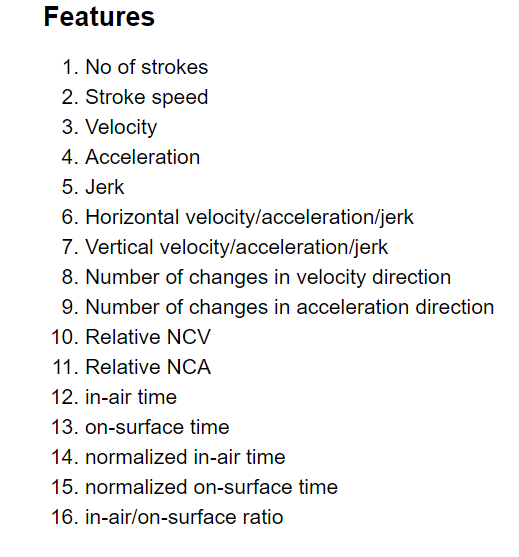

FEATURE EXTRACTION

In [15]:

import pandas as pd
import numpy as np
import os
import tensorflow as tf
import keras
import csv
from matplotlib import pyplot as plt
def read(file):
    with open(file) as f:
        reader = csv.reader(f,delimiter = ';')
        patient_data = []
        data = []
        for row in reader:
            for k in range(len(row)):
                row[k]= int(row[k])
            data.append(row)
    return data

path = '/content/drive/MyDrive/Kaggle/datanew/hw_dataset/'
path2= '/content/drive/MyDrive/Kaggle/datanew/new_dataset/'
hw = []
hw.append([])
hw.append([])
hw.append([])
for f in os.listdir(path+'hw_dataset/control/'):
    hw[0].append(read(path+'hw_dataset/control/'+f))
    
for f in os.listdir(path+'hw_dataset/parkinson/'):
    hw[1].append(read(path+'hw_dataset/parkinson/'+f))
    
for f in os.listdir(path2+'new_dataset/parkinson/'):
    hw[2].append(read(path2+'new_dataset/parkinson/'+f))
count = 0
dfs  = []
for i in range(3):
    for k in range(len(hw[i])):
        df = pd.DataFrame(hw[i][k],columns = ['x','y','z','Pressure','GripAngle','TimeStamp','testID'])
        #first folder is control, everything else is parkinson
        if i == 0:
            isPark = 0
        else:
            isPark = 1
        df['isParkinson'] = pd.Series(np.full((len(df),),isPark))
        df['ID'] = pd.Series(np.full((len(df),),count))
        dfs.append(df)
        count+=1
dfs[0].head(20)

,x,y,z,Pressure,GripAngle,TimeStamp,testID,isParkinson,ID
0,199,203,0,1,990,14431033,0,0,0
1,199,203,0,9,970,14431040,0,0,0
2,199,203,0,20,960,14431047,0,0,0
3,199,203,0,30,970,14431054,0,0,0
4,199,203,0,45,970,14431061,0,0,0
5,199,203,0,58,970,14431068,0,0,0
6,199,203,0,67,990,14431075,0,0,0
7,199,203,0,76,970,14431082,0,0,0
8,199,203,0,81,970,14431089,0,0,0
9,199,203,0,84,990,14431096,0,0,0


In [16]:
dfs[0].head(70)

,x,y,z,Pressure,GripAngle,TimeStamp,testID,isParkinson,ID
0,199,203,0,1,990,14431033,0,0,0
1,199,203,0,9,970,14431040,0,0,0
2,199,203,0,20,960,14431047,0,0,0
3,199,203,0,30,970,14431054,0,0,0
4,199,203,0,45,970,14431061,0,0,0
...,...,...,...,...,...,...,...,...,...
65,198,203,0,442,980,14431490,0,0,0
66,198,203,0,445,980,14431497,0,0,0
67,198,203,0,446,980,14431504,0,0,0
68,198,203,0,449,980,14431512,0,0,0


In [17]:
header_row=["X", "Y", "Z", "Pressure" , "GripAngle" , "Timestamp" , "Test_ID"]

In [18]:
#@timeit
def get_no_strokes(df):
    pressure_data=df['Pressure'].to_numpy()
    on_surface = (pressure_data>600).astype(int)
    return ((np.roll(on_surface, 1) - on_surface) != 0).astype(int).sum()

In [19]:
#@timeit
def get_speed(df):
    total_dist=0
    duration=df['Timestamp'].to_numpy()[-1]
    coords=df[['X', 'Y', 'Z']].to_numpy()
    for i in range(10, df.shape[0]):
        temp=np.linalg.norm(coords[i, :]-coords[i-10, :])
        total_dist+=temp
    speed=total_dist/duration
    return speed

In [20]:
#@timeit
def get_in_air_time(data):
    data=data['Pressure'].to_numpy()
    return (data<600).astype(int).sum()

In [21]:
#@timeit
def get_on_surface_time(data):
    data=data['Pressure'].to_numpy()
    return (data>600).astype(int).sum()

In [22]:
def find_velocity(f):
    '''
    change in direction and its position
    
    '''
    data_pat=f
    Vel = []
    horz_Vel = []
    horz_vel_mag = []
    vert_vel_mag = []
    vert_Vel = []
    magnitude = []
    timestamp_diff =  []
    
    t = 0
    for i in range(len(data_pat)-2):
        if t+10 <= len(data_pat)-1:
            Vel.append(((data_pat['X'].to_numpy()[t+10] - data_pat['X'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t]) , (data_pat['Y'].to_numpy()[t+10]-data_pat['Y'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t])))
            horz_Vel.append((data_pat['X'].to_numpy()[t+10] - data_pat['X'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t]))
            
            vert_Vel.append((data_pat['Y'].to_numpy()[t+10] - data_pat['Y'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t]))
            magnitude.append(sqrt(((data_pat['X'].to_numpy()[t+10]-data_pat['X'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t]))**2 + (((data_pat['Y'].to_numpy()[t+10]-data_pat['Y'].to_numpy()[t])/(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t]))**2)))
            timestamp_diff.append(data_pat['Timestamp'].to_numpy()[t+10]-data_pat['Timestamp'].to_numpy()[t])
            horz_vel_mag.append(abs(horz_Vel[len(horz_Vel)-1]))
            vert_vel_mag.append(abs(vert_Vel[len(vert_Vel)-1]))
            t = t+10
        else:
            break
    magnitude_vel = np.mean(magnitude)  
    magnitude_horz_vel = np.mean(horz_vel_mag)
    magnitude_vert_vel = np.mean(vert_vel_mag)
    return Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel

In [23]:
def find_acceleration(f):
    '''
    change in direction and its velocity
   
    '''
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(f)
    accl = []
    horz_Accl =  []
    vert_Accl = []
    magnitude = []
    horz_acc_mag = []
    vert_acc_mag = []
    for i in range(len(Vel)-2):
        accl.append(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i] , (Vel[i+1][1]-Vel[i][1])/timestamp_diff[i]))
        horz_Accl.append((horz_Vel[i+1]-horz_Vel[i])/timestamp_diff[i])
        vert_Accl.append((vert_Vel[i+1]-vert_Vel[i])/timestamp_diff[i])
        horz_acc_mag.append(abs(horz_Accl[len(horz_Accl)-1]))
        vert_acc_mag.append(abs(vert_Accl[len(vert_Accl)-1]))
        magnitude.append(sqrt(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i])**2 + ((Vel[i+1][1]-Vel[i][1])/timestamp_diff[i])**2))
    
    magnitude_acc = np.mean(magnitude)  
    magnitude_horz_acc = np.mean(horz_acc_mag)
    magnitude_vert_acc = np.mean(vert_acc_mag)
    return accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc

In [24]:
def find_jerk(f):
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc = find_acceleration(f)
    jerk = []
    hrz_jerk = []
    vert_jerk = []
    magnitude = []
    horz_jerk_mag = []
    vert_jerk_mag = []
    
    for i in range(len(accl)-2):
        jerk.append(((accl[i+1][0]-accl[i][0])/timestamp_diff[i] , (accl[i+1][1]-accl[i][1])/timestamp_diff[i]))
        hrz_jerk.append((horz_Accl[i+1]-horz_Accl[i])/timestamp_diff[i])
        vert_jerk.append((vert_Accl[i+1]-vert_Accl[i])/timestamp_diff[i])
        horz_jerk_mag.append(abs(hrz_jerk[len(hrz_jerk)-1]))
        vert_jerk_mag.append(abs(vert_jerk[len(vert_jerk)-1]))
        magnitude.append(sqrt(((accl[i+1][0]-accl[i][0])/timestamp_diff[i])**2 + ((accl[i+1][1]-accl[i][1])/timestamp_diff[i])**2))
        
    magnitude_jerk = np.mean(magnitude)  
    magnitude_horz_jerk = np.mean(horz_jerk_mag)
    magnitude_vert_jerk = np.mean(vert_jerk_mag)
    return jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk

In [25]:
def NCV_per_halfcircle(f):
    data_pat=f
    Vel = []
    ncv = []
    temp_ncv = 0
    basex = data_pat['X'].to_numpy()[0]
    for i in range(len(data_pat)-2):
        if data_pat['X'].to_numpy()[i] == basex:
            ncv.append(temp_ncv)
            temp_ncv = 0
            continue
            
        Vel.append(((data_pat['X'].to_numpy()[i+1] - data_pat['X'].to_numpy()[i])/(data_pat['Timestamp'].to_numpy()[i+1]-data_pat['Timestamp'].to_numpy()[i]) , (data_pat['Y'].to_numpy()[i+1]-data_pat['Y'].to_numpy()[i])/(data_pat['Timestamp'].to_numpy()[i+1]-data_pat['Timestamp'].to_numpy()[i])))
        if Vel[len(Vel)-1] != (0,0):
            temp_ncv+=1
    ncv.append(temp_ncv)
    #ncv = list(filter((2).__ne__, ncv))
    ncv_Val = np.sum(ncv)/np.count_nonzero(ncv)
    return ncv,ncv_Val

In [26]:
def NCA_per_halfcircle(f):
    data_pat=f
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(f)
    accl = []
    nca = []
    temp_nca = 0
    basex = data_pat['X'].to_numpy()[0]
    for i in range(len(Vel)-2):
        if data_pat['X'].to_numpy()[i] == basex:
            nca.append(temp_nca)
            #print ('tempNCa::',temp_nca)
            temp_nca = 0
            continue
            
        accl.append(((Vel[i+1][0]-Vel[i][0])/timestamp_diff[i] , (Vel[i+1][1]-Vel[i][1])/timestamp_diff[i]))
        if accl[len(accl)-1] != (0,0):
            temp_nca+=1
    nca.append(temp_nca)
    nca = list(filter((2).__ne__, nca))
    nca_Val = np.sum(nca)/np.count_nonzero(nca)
    return nca,nca_Val

In [27]:
#@timeit
def get_features(f, parkinson_target):
    global header_row
    df=pd.read_csv(f, sep=';', header=None, names=header_row)
    
    df_static=df[df["Test_ID"]==0]    # static test
    df_dynamic=df[df["Test_ID"]==1]    # dynamic test
    df_stcp=df[df["Test_ID"]==2]    # STCP
    #df_static_dynamic=pd.concat([df_static, df_dynamic])
    
    initial_timestamp=df['Timestamp'][0]
    df['Timestamp']=df['Timestamp']- initial_timestamp # offset timestamps
    
    duration_static = df_static['Timestamp'].to_numpy()[-1] if df_static.shape[0] else 1
    duration_dynamic = df_dynamic['Timestamp'].to_numpy()[-1] if df_dynamic.shape[0] else 1
    duration_STCP = df_stcp['Timestamp'].to_numpy()[-1] if df_stcp.shape[0] else 1

    
    data_point=[]
    data_point.append(get_no_strokes(df_static) if df_static.shape[0] else 0) # no. of strokes for static test
    data_point.append(get_no_strokes(df_dynamic) if df_dynamic.shape[0] else 0) # no. of strokes for dynamic test
    data_point.append(get_speed(df_static) if df_static.shape[0] else 0) # speed for static test
    data_point.append(get_speed(df_dynamic) if df_dynamic.shape[0] else 0) # speed for dynamic test

    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of velocity, horizontal velocity and vertical velocity for static test
    data_point.extend([magnitude_vel, magnitude_horz_vel,magnitude_vert_vel])
    Vel,magnitude,timestamp_diff,horz_Vel,vert_Vel,magnitude_vel,magnitude_horz_vel,magnitude_vert_vel = find_velocity(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of velocity, horizontal velocity and vertical velocity for dynamic test
    data_point.extend([magnitude_vel, magnitude_horz_vel,magnitude_vert_vel])
    
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc=find_acceleration(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0)# magnitudes of acceleration, horizontal acceleration and vertical acceleration for static test        
    data_point.extend([magnitude_acc,magnitude_horz_acc,magnitude_vert_acc])
    accl,magnitude,horz_Accl,vert_Accl,timestamp_diff,magnitude_acc,magnitude_horz_acc,magnitude_vert_acc=find_acceleration(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0)# magnitudes of acceleration, horizontal acceleration and vertical acceleration for dynamic test        
    data_point.extend([magnitude_acc,magnitude_horz_acc,magnitude_vert_acc])
    
    jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk=find_jerk(df_static) if df_static.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of jerk, horizontal jerk and vertical jerk for static test
    data_point.extend([magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk])
    jerk,magnitude,hrz_jerk,vert_jerk,timestamp_diff,magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk=find_jerk(df_dynamic) if df_dynamic.shape[0] else (0,0,0,0,0,0,0,0) # magnitudes of jerk, horizontal jerk and vertical jerk for dynamic test
    data_point.extend([magnitude_jerk,magnitude_horz_jerk,magnitude_vert_jerk])
    
    ncv,ncv_Val=NCV_per_halfcircle(df_static) if df_static.shape[0] else (0,0) # NCV for static test
    data_point.append(ncv_Val)
    ncv,ncv_Val=NCV_per_halfcircle(df_dynamic) if df_dynamic.shape[0] else (0,0) # NCV for dynamic test
    data_point.append(ncv_Val)
    
    nca,nca_Val=NCA_per_halfcircle(df_static) if df_static.shape[0] else (0,0) # NCA for static test
    data_point.append(nca_Val)
    nca,nca_Val=NCA_per_halfcircle(df_dynamic) if df_dynamic.shape[0] else (0,0) # NCA for dynamic test
    data_point.append(nca_Val)
    
    data_point.append(get_in_air_time(df_stcp) if df_stcp.shape[0] else 0) # in air time for STCP
    data_point.append(get_on_surface_time(df_static) if df_static.shape[0] else 0) # on surface time for static test
    data_point.append(get_on_surface_time(df_dynamic) if df_dynamic.shape[0] else 0) # on surface time for dynamic test
    
    data_point.append(parkinson_target)    # traget. 1 for parkinson. 0 for control.
    
    return data_point

In [28]:
temp_feat=get_features(parkinson_file_list[10], 1)

In [29]:
print(temp_feat)

[4, 6, 0.010126987814961172, 0.009184125353444633, 0.05445614802965261, 0.03569787758649744, 0.03317427796846683, 0.0760646320500834, 0.049734326975706296, 0.04842743463433118, 0.00018766015065952324, 0.00012527728836561933, 0.00010431866995416987, 0.00020000048209027846, 0.0001259588197418885, 0.00011917547962521506, 3.4693836745563745e-06, 2.335721071757737e-06, 2.0102842342453857e-06, 3.2294283608720504e-06, 2.049743698924486e-06, 2.016946716153461e-06, 210.3, 319.5, 67.2, 262.0, 1221, 2712, 2337, 1]


In [30]:
len(parkinson_file_list)

64

In [33]:
raw=[]
for x in parkinson_file_list:
    raw.append(get_features(x, 1))
for x in control_file_list:
    raw.append(get_features(x, 0))

In [34]:
raw=np.array(raw)

In [35]:
features_headers=['no_strokes_st', 'no_strokes_dy', 'speed_st', 'speed_dy', 'magnitude_vel_st' , 'magnitude_horz_vel_st' , 'magnitude_vert_vel_st', 'magnitude_vel_dy', 'magnitude_horz_vel_dy' , 'magnitude_vert_vel_dy', 'magnitude_acc_st' , 'magnitude_horz_acc_st' , 'magnitude_vert_acc_st','magnitude_acc_dy' , 'magnitude_horz_acc_dy' , 'magnitude_vert_acc_dy', 'magnitude_jerk_st', 'magnitude_horz_jerk_st' , 'magnitude_vert_jerk_st', 'magnitude_jerk_dy', 'magnitude_horz_jerk_dy' , 'magnitude_vert_jerk_dy', 'ncv_st', 'ncv_dy', 'nca_st', 'nca_dy', 'in_air_stcp','on_surface_st', 'on_surface_dy', 'target']

In [36]:
data=pd.DataFrame(raw, columns=features_headers)

In [37]:
data.tail()

,no_strokes_st,no_strokes_dy,speed_st,speed_dy,magnitude_vel_st,magnitude_horz_vel_st,magnitude_vert_vel_st,magnitude_vel_dy,magnitude_horz_vel_dy,magnitude_vert_vel_dy,magnitude_acc_st,magnitude_horz_acc_st,magnitude_vert_acc_st,magnitude_acc_dy,magnitude_horz_acc_dy,magnitude_vert_acc_dy,magnitude_jerk_st,magnitude_horz_jerk_st,magnitude_vert_jerk_st,magnitude_jerk_dy,magnitude_horz_jerk_dy,magnitude_vert_jerk_dy,ncv_st,ncv_dy,nca_st,nca_dy,in_air_stcp,on_surface_st,on_surface_dy,target
75,0.0,0.0,0.001152,0.001140,0.103493,0.066596,0.064488,0.106868,0.068777,0.067774,0.000400,0.000241,0.000258,0.000409,0.000249,0.000256,0.000009,0.000005,0.000006,0.000008,0.000005,0.000006,277.285714,266.285714,81.333333,117.000000,1536.0,0.0,0.0,0.0
76,2.0,2.0,0.069104,0.061284,0.091484,0.057594,0.058259,0.089721,0.056244,0.057436,0.000363,0.000203,0.000246,0.000333,0.000219,0.000198,0.000008,0.000005,0.000006,0.000007,0.000005,0.000004,255.125000,282.000000,70.750000,140.000000,0.0,2994.0,3064.0,0.0
77,6.0,10.0,0.001159,0.001157,0.150016,0.095055,0.095358,0.136387,0.090064,0.085038,0.000554,0.000377,0.000327,0.000475,0.000327,0.000268,0.000010,0.000007,0.000006,0.000009,0.000007,0.000005,189.125000,234.571429,14.000000,58.333333,1536.0,835.0,363.0,0.0
78,2.0,2.0,0.001387,0.001339,0.088510,0.055965,0.055433,0.114583,0.073060,0.070357,0.000385,0.000247,0.000230,0.000426,0.000292,0.000243,0.000009,0.000006,0.000005,0.000009,0.000006,0.000005,224.222222,227.125000,71.500000,73.666667,1536.0,3029.0,2312.0,0.0
79,2.0,2.0,0.000012,0.000012,0.101776,0.064709,0.064496,0.112287,0.072237,0.069907,0.000342,0.000194,0.000227,0.000347,0.000208,0.000216,0.000007,0.000004,0.000005,0.000007,0.000004,0.000005,270.000000,253.714286,127.500000,109.000000,0.0,2670.0,2363.0,0.0


In [38]:
data.head()

,no_strokes_st,no_strokes_dy,speed_st,speed_dy,magnitude_vel_st,magnitude_horz_vel_st,magnitude_vert_vel_st,magnitude_vel_dy,magnitude_horz_vel_dy,magnitude_vert_vel_dy,magnitude_acc_st,magnitude_horz_acc_st,magnitude_vert_acc_st,magnitude_acc_dy,magnitude_horz_acc_dy,magnitude_vert_acc_dy,magnitude_jerk_st,magnitude_horz_jerk_st,magnitude_vert_jerk_st,magnitude_jerk_dy,magnitude_horz_jerk_dy,magnitude_vert_jerk_dy,ncv_st,ncv_dy,nca_st,nca_dy,in_air_stcp,on_surface_st,on_surface_dy,target
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
2,2.0,6.0,0.001793,0.001434,0.041127,0.026362,0.025751,0.059535,0.037716,0.038586,0.000159,0.000095,0.000098,0.000194,0.000118,0.000118,0.000003,0.000002,0.000002,0.000004,0.000002,0.000002,315.714286,299.666667,212.000000,285.0,705.0,4025.0,2487.0,1.0
3,22.0,12.0,0.001636,0.001620,0.128316,0.083959,0.079109,0.068212,0.042802,0.043473,0.000409,0.000266,0.000253,0.000270,0.000175,0.000163,0.000005,0.000003,0.000003,0.000004,0.000003,0.000003,205.714286,262.285714,53.666667,83.0,206.0,1369.0,2807.0,1.0
4,54.0,34.0,0.003032,0.002656,0.092602,0.060102,0.057756,0.104627,0.067375,0.066732,0.000406,0.000235,0.000277,0.000422,0.000244,0.000289,0.000008,0.000004,0.000005,0.000007,0.000004,0.000005,310.000000,334.750000,225.000000,75.5,1497.0,1881.0,1592.0,1.0


In [39]:
data.to_csv('data.csv')

In [40]:

print('data shape', data.shape)

data shape (80, 30)


In [41]:
pos=data[data['target']==1]
neg=data[data['target']==0]

train_pos=pos.head(pos.shape[0]-5)
train_neg=neg.head(pos.shape[0]-5)
train=pd.concat([train_pos, train_neg])
print('train shape', train.shape)

test_pos=pos.tail(5)
test_neg=neg.tail(5)
test=pd.concat([test_pos, test_neg])


train_y=train['target']
train_x=train.drop(['target'], axis=1)
test_y=test['target']
test_x=test.drop(['target'], axis=1)

train shape (75, 30)


In [42]:
train_y

0     1.0
1     1.0
2     1.0
3     1.0
4     1.0
     ... 
75    0.0
76    0.0
77    0.0
78    0.0
79    0.0
Name: target, Length: 75, dtype: float64

In [43]:
train_x

,no_strokes_st,no_strokes_dy,speed_st,speed_dy,magnitude_vel_st,magnitude_horz_vel_st,magnitude_vert_vel_st,magnitude_vel_dy,magnitude_horz_vel_dy,magnitude_vert_vel_dy,magnitude_acc_st,magnitude_horz_acc_st,magnitude_vert_acc_st,magnitude_acc_dy,magnitude_horz_acc_dy,magnitude_vert_acc_dy,magnitude_jerk_st,magnitude_horz_jerk_st,magnitude_vert_jerk_st,magnitude_jerk_dy,magnitude_horz_jerk_dy,magnitude_vert_jerk_dy,ncv_st,ncv_dy,nca_st,nca_dy,in_air_stcp,on_surface_st,on_surface_dy
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,2.0,6.0,0.001793,0.001434,0.041127,0.026362,0.025751,0.059535,0.037716,0.038586,0.000159,0.000095,0.000098,0.000194,0.000118,0.000118,0.000003,0.000002,0.000002,0.000004,0.000002,0.000002,315.714286,299.666667,212.000000,285.000000,705.0,4025.0,2487.0
3,22.0,12.0,0.001636,0.001620,0.128316,0.083959,0.079109,0.068212,0.042802,0.043473,0.000409,0.000266,0.000253,0.000270,0.000175,0.000163,0.000005,0.000003,0.000003,0.000004,0.000003,0.000003,205.714286,262.285714,53.666667,83.000000,206.0,1369.0,2807.0
4,54.0,34.0,0.003032,0.002656,0.092602,0.060102,0.057756,0.104627,0.067375,0.066732,0.000406,0.000235,0.000277,0.000422,0.000244,0.000289,0.000008,0.000004,0.000005,0.000007,0.000004,0.000005,310.000000,334.750000,225.000000,75.500000,1497.0,1881.0,1592.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.0,0.0,0.001152,0.001140,0.103493,0.066596,0.064488,0.106868,0.068777,0.067774,0.000400,0.000241,0.000258,0.000409,0.000249,0.000256,0.000009,0.000005,0.000006,0.000008,0.000005,0.000006,277.285714,266.285714,81.333333,117.000000,1536.0,0.0,0.0
76,2.0,2.0,0.069104,0.061284,0.091484,0.057594,0.058259,0.089721,0.056244,0.057436,0.000363,0.000203,0.000246,0.000333,0.000219,0.000198,0.000008,0.000005,0.000006,0.000007,0.000005,0.000004,255.125000,282.000000,70.750000,140.000000,0.0,2994.0,3064.0
77,6.0,10.0,0.001159,0.001157,0.150016,0.095055,0.095358,0.136387,0.090064,0.085038,0.000554,0.000377,0.000327,0.000475,0.000327,0.000268,0.000010,0.000007,0.000006,0.000009,0.000007,0.000005,189.125000,234.571429,14.000000,58.333333,1536.0,835.0,363.0
78,2.0,2.0,0.001387,0.001339,0.088510,0.055965,0.055433,0.114583,0.073060,0.070357,0.000385,0.000247,0.000230,0.000426,0.000292,0.000243,0.000009,0.000006,0.000005,0.000009,0.000006,0.000005,224.222222,227.125000,71.500000,73.666667,1536.0,3029.0,2312.0


In [44]:
test_y

59    1.0
60    1.0
61    1.0
62    1.0
63    1.0
75    0.0
76    0.0
77    0.0
78    0.0
79    0.0
Name: target, dtype: float64

In [45]:
test_x

,no_strokes_st,no_strokes_dy,speed_st,speed_dy,magnitude_vel_st,magnitude_horz_vel_st,magnitude_vert_vel_st,magnitude_vel_dy,magnitude_horz_vel_dy,magnitude_vert_vel_dy,magnitude_acc_st,magnitude_horz_acc_st,magnitude_vert_acc_st,magnitude_acc_dy,magnitude_horz_acc_dy,magnitude_vert_acc_dy,magnitude_jerk_st,magnitude_horz_jerk_st,magnitude_vert_jerk_st,magnitude_jerk_dy,magnitude_horz_jerk_dy,magnitude_vert_jerk_dy,ncv_st,ncv_dy,nca_st,nca_dy,in_air_stcp,on_surface_st,on_surface_dy
59,2.0,2.0,0.004495,0.004138,0.282933,0.232494,0.124390,0.233773,0.191026,0.102773,0.001433,0.001273,0.000421,0.001167,0.001010,0.000403,0.000028,0.000026,0.000007,0.000024,0.000022,0.000007,643.000000,193.428571,135.000000,37.750000,0.0,1170.0,1527.0
60,44.0,0.0,0.000009,0.000009,0.157871,0.103463,0.093055,0.207649,0.130071,0.130124,0.000620,0.000362,0.000415,0.001358,0.000831,0.000982,0.000012,0.000007,0.000009,0.000030,0.000018,0.000023,174.555556,443.666667,89.000000,147.000000,2267.0,513.0,0.0
61,0.0,0.0,0.000010,0.000009,0.208928,0.130988,0.133271,0.199471,0.122773,0.133141,0.000773,0.000553,0.000410,0.000840,0.000530,0.000546,0.000013,0.000010,0.000006,0.000011,0.000009,0.000005,174.500000,264.333333,31.000000,96.000000,2403.0,0.0,0.0
62,2.0,2.0,0.000251,0.000238,0.199831,0.128719,0.124814,0.275863,0.171905,0.178293,0.000680,0.000432,0.000444,0.001092,0.000690,0.000710,0.000012,0.000009,0.000007,0.000015,0.000010,0.000009,135.888889,208.250000,19.833333,24.000000,0.0,1299.0,885.0
63,16.0,2.0,0.000011,0.000015,0.158056,0.099742,0.101824,0.292125,0.184873,0.190290,0.000469,0.000261,0.000329,0.001137,0.000691,0.000761,0.000009,0.000005,0.000007,0.000015,0.000009,0.000011,261.166667,230.200000,78.000000,40.000000,2181.0,1117.0,1059.0
75,0.0,0.0,0.001152,0.001140,0.103493,0.066596,0.064488,0.106868,0.068777,0.067774,0.000400,0.000241,0.000258,0.000409,0.000249,0.000256,0.000009,0.000005,0.000006,0.000008,0.000005,0.000006,277.285714,266.285714,81.333333,117.000000,1536.0,0.0,0.0
76,2.0,2.0,0.069104,0.061284,0.091484,0.057594,0.058259,0.089721,0.056244,0.057436,0.000363,0.000203,0.000246,0.000333,0.000219,0.000198,0.000008,0.000005,0.000006,0.000007,0.000005,0.000004,255.125000,282.000000,70.750000,140.000000,0.0,2994.0,3064.0
77,6.0,10.0,0.001159,0.001157,0.150016,0.095055,0.095358,0.136387,0.090064,0.085038,0.000554,0.000377,0.000327,0.000475,0.000327,0.000268,0.000010,0.000007,0.000006,0.000009,0.000007,0.000005,189.125000,234.571429,14.000000,58.333333,1536.0,835.0,363.0
78,2.0,2.0,0.001387,0.001339,0.088510,0.055965,0.055433,0.114583,0.073060,0.070357,0.000385,0.000247,0.000230,0.000426,0.000292,0.000243,0.000009,0.000006,0.000005,0.000009,0.000006,0.000005,224.222222,227.125000,71.500000,73.666667,1536.0,3029.0,2312.0
79,2.0,2.0,0.000012,0.000012,0.101776,0.064709,0.064496,0.112287,0.072237,0.069907,0.000342,0.000194,0.000227,0.000347,0.000208,0.000216,0.000007,0.000004,0.000005,0.000007,0.000004,0.000005,270.000000,253.714286,127.500000,109.000000,0.0,2670.0,2363.0


In [58]:
def accuracy(prediction,actual):
    correct = 0
    not_correct = 0
    for i in range(len(prediction)):
        if prediction[i] == actual[i]:
            correct+=1
        else:
            not_correct+=1
    return (correct*100)/(correct+not_correct)


def metrics(prediction,actual):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(prediction)):
        if prediction[i] == actual[i] and actual[i]==1:
            tp+=1
        if prediction[i] == actual[i] and actual[i]==0:
            tn+=1
        if prediction[i] != actual[i] and actual[i]==0:
            fp+=1
        if prediction[i] != actual[i] and actual[i]==1:
            fn+=1
    metrics = {'Precision':(tp/(tp+fp+tn+fn)),'Recall':(tp/(tp+fn)),'F1':(2*(tp/(tp+fp+tn+fn))*(tp/(tp+fn)))/((tp/(tp+fp+tn+fn))+(tp/(tp+fn)))}
    return (metrics)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [48]:
clf=LogisticRegression()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 50.0 %
{'Precision': 0.5, 'Recall': 0.5, 'F1': 0.5}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [49]:
clf=RandomForestClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))


accuracy: 100.0 %
{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


In [50]:
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
le = LabelEncoder()

trainY = le.fit_transform(train_y)
testY = le.transform(test_y)

In [51]:
trainY

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [52]:
testY

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [53]:

from sklearn.metrics import classification_report,confusion_matrix
cnf = confusion_matrix(testY,preds)
cnf

array([[5, 0],
       [0, 5]])

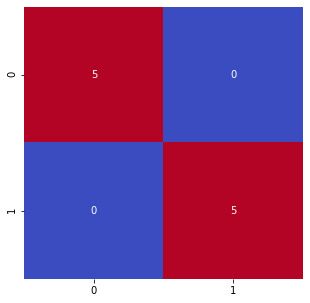

In [54]:
plt.figure(figsize=(5,5))
sns.heatmap(cnf , annot=True , cmap="coolwarm" , cbar=False)
plt.show()

In [55]:
from sklearn import metrics
acc = metrics.accuracy_score(testY,preds)
acc

1.0

In [59]:
clf=SVC()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 50.0 %
{'Precision': 0.5, 'Recall': 0.5, 'F1': 0.5}


In [61]:
clf=DecisionTreeClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 100.0 %
{'Precision': 0.5, 'Recall': 1.0, 'F1': 0.6666666666666666}


In [62]:

clf=KNeighborsClassifier()
clf.fit(train_x, train_y)
preds=clf.predict(test_x)
print('accuracy:',accuracy(test_y.tolist(), preds.tolist()), '%')
print(metrics(test_y.tolist(), preds.tolist()))

accuracy: 70.0 %
{'Precision': 0.5, 'Recall': 0.625, 'F1': 0.5555555555555556}


PLOT

In [63]:
def plot(f, plot_func, t_id=0, x=None, y=None, reg_plot=True):
    global header_row
    df=pd.read_csv(f, sep=';', header=None, names=header_row)
    df=df[df["Test_ID"]==t_id]
    initial_timestamp=df['Timestamp'][0]
    df['Timestamp']=df['Timestamp']- initial_timestamp
    if reg_plot:
        plot_func(data=df, x=x, y=y, fit_reg=False, scatter_kws={"s": 0.5})
    else:
        plot_func(data=df, x=x, y=y)
    print(metrics(test_y.tolist(), preds.tolist()))

Pressure (Parkinsons)

{'Precision': 0.5, 'Recall': 0.625, 'F1': 0.5555555555555556}


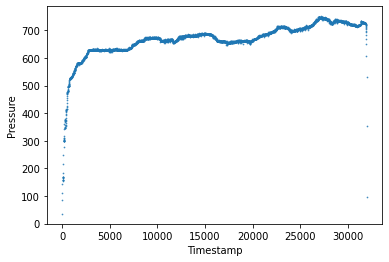

In [64]:
plot(f=parkinson_file_list[51],  plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')

Pressure (Control)

{'Precision': 0.5, 'Recall': 0.625, 'F1': 0.5555555555555556}


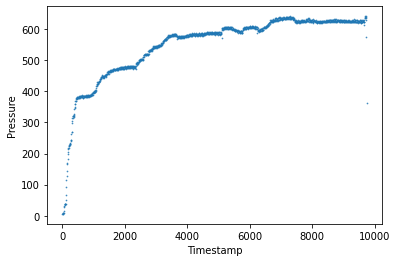

In [65]:

plot(control_file_list[4], plot_func=sns.regplot, t_id=0, x='Timestamp', y='Pressure')

{'Precision': 0.5, 'Recall': 0.625, 'F1': 0.5555555555555556}


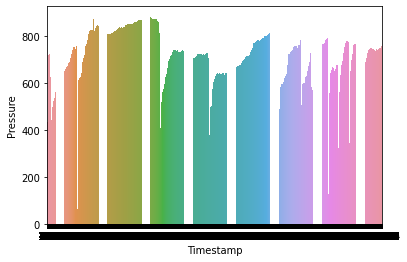

In [66]:
plot(f=parkinson_file_list[24], plot_func=sns.barplot, t_id=0, x='Timestamp', y='Pressure', reg_plot=False)

In [67]:
def show_spiral(data,test_num = 0,num=None):
    x = []
    y = []
    for row in data:
        if row[6] == test_num:
            x.append(row[0])
            y.append(row[1])
    fig, ax = plt.subplots()
    ax.plot(x,y,'b-')

    ax.set_title(str(0))
#     plt.plot(x,y,'b-')
    plt.show()

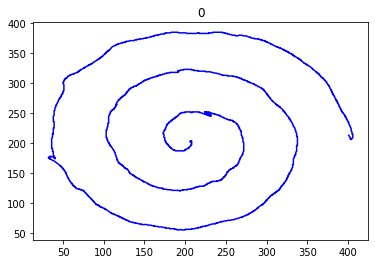

In [68]:
show_spiral(hw[1][0])

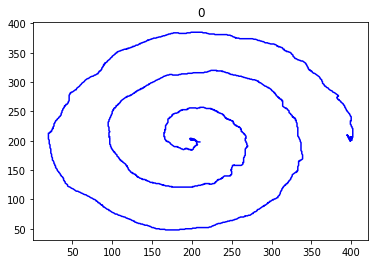

In [69]:
show_spiral(hw[1][2])

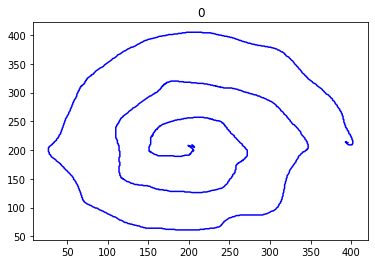

In [70]:
show_spiral(hw[1][1])

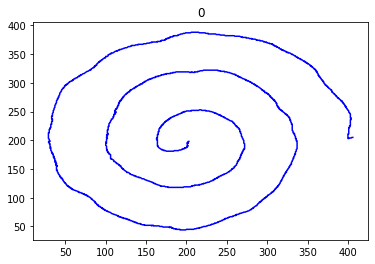

In [71]:
show_spiral(hw[1][3])

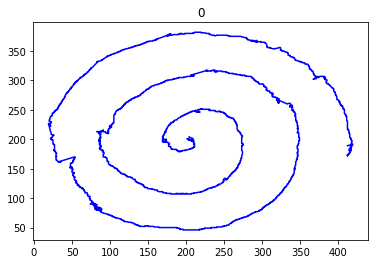

In [72]:
show_spiral(hw[1][22])

In [73]:
import keras
import PIL
import numpy as np
import os
from matplotlib.pyplot import imshow
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

In [74]:
import glob

In [75]:
from scipy.ndimage import convolve
from sklearn import metrics
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM as fe
import pandas as pd
import numpy as np
import glob

In [76]:
control_path = "/content/drive/MyDrive/Kaggle/datanew/hw_dataset/hw_dataset/control"
parkinson_path = "/content/drive/MyDrive/Kaggle/datanew/hw_dataset/hw_dataset/parkinson"


def getFiles(path):
    all_files = glob.glob(path + "/*.txt")
    data = []

    for file in all_files:
        df = pd.read_csv(file,sep=";")
        data.append(df)
    
    return data
         

def extractFeatures(df):
    features = []
    features.append(np.argmax( df.values[:,0]) - np.argmin( df.values[:,0]))
    features.append(np.argmax( df.values[:,1]) - np.argmin( df.values[:,1]))
    features.append(np.argmax( df.values[:,2]) - np.argmin( df.values[:,2]))
    features.append(np.argmax( df.values[:,3]) - np.argmin( df.values[:,3]))
    features.append(np.argmax( df.values[:,4]) - np.argmin( df.values[:,4]))
    return features
    

def getControlFeatures():
    control_data = []
    control = getFiles(control_path)
    for i in control:
        new_df = splitByTest(i)
        for k in range(new_df.shape[0]):
            last_df = np.array_split(i,40)
            for j in last_df:
                control_data.append(extractFeatures(j))
    return pd.DataFrame(control_data)


def getParkinsonFeatures():
    parkinson_data = []
    parkinson = getFiles(parkinson_path)
    for i in parkinson:
        new_df = splitByTest(i)
        for k in range(new_df.shape[0]):
            last_df = np.array_split(i,40)
            for j in last_df:
                parkinson_data.append(extractFeatures(j))
    return pd.DataFrame(parkinson_data)


def getClasses(control, parkinson):
    classes = []
    for i in range(control.shape[0]):
        classes.append(0)
    for i in range(parkinson.shape[0]):
        classes.append(1)
    res = np.array(classes)

    return res

def splitByTest(df):
    data = []
    test = df.values[0][6]
    split = []
    cont = 0
    for i in range(df.shape[0]):
        if df.values[i][6] == test:
            split.append(df.values[i])
        else:
            aux = pd.DataFrame(split)
            data.append(aux)
            split = []
            test = df.values[i][6]
            split.append(df.values[i])
    data.append(split)
    return pd.DataFrame(data)

RBM

In [77]:
rbm = BernoulliRBM( verbose=True)

rbm.learning_rate = 0.0002
rbm.n_iter = 300

rbm.n_components = 200

MLP and pipeline

In [78]:
mlp = MLPClassifier(alpha=1e-08, hidden_layer_sizes=(70,10),solver='adam',
                    activation='relu',  learning_rate_init = .0005,
                    max_iter=5000, momentum = 0.7)

rbm_features_classifier = Pipeline(steps=[('rbm', rbm), ('MLP', mlp)])

In [79]:
data = getControlFeatures()
park = getParkinsonFeatures()

def getClasses(control, parkinson):
    classes = []
    for i in range(control.shape[0]):
        classes.append(0)
    for i in range(parkinson.shape[0]):
        classes.append(1)
    res = np.array(classes)

    return res
all_data = np.concatenate((data,park),axis= 0)
target = getClasses(data,park)

train_data, test_data, train_target, test_target = train_test_split(all_data,target, test_size= 0.3, random_state=30 )

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [80]:
train_data, test_data, train_target, test_target = train_test_split(all_data,target, test_size= 0.3, random_state=30 )

rbm_features_classifier.fit(train_data, train_target)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -92837.90, time = 0.15s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -191652.09, time = 0.30s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -295609.38, time = 0.31s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -381015.32, time = 0.30s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -517742.21, time = 0.29s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -567937.15, time = 0.29s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -636627.09, time = 0.29s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -822304.74, time = 0.29s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -866109.44, time = 0.29s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -916453.00, time = 0.30s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -1130293.07, time = 0.29s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -1142464.97, time = 0.29s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -1261636.20, time = 0.29s
[BernoulliRBM] Iteration 14, pseudo-likelihoo

Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.0002,
                              n_components=200, n_iter=300, random_state=None,
                              verbose=True)),
                ('MLP',
                 MLPClassifier(activation='relu', alpha=1e-08,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(70, 10),
                               learning_rate='constant',
                               learning_rate_init=0.0005, max_fun=15000,
                               max_iter=5000, momentum=0.7, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False

In [81]:
Y_pred = rbm_features_classifier.predict(test_data)

print(confusion_matrix(Y_pred, test_target))
print(accuracy_score(Y_pred, test_target))

[[   9    5]
 [ 426 1984]]
0.8221947194719472


In [82]:
print("MLP using RBM features:\n%s\n" % (
    metrics.classification_report(test_target, Y_pred)))

MLP using RBM features:
              precision    recall  f1-score   support

           0       0.64      0.02      0.04       435
           1       0.82      1.00      0.90      1989

    accuracy                           0.82      2424
   macro avg       0.73      0.51      0.47      2424
weighted avg       0.79      0.82      0.75      2424




In [83]:
clf = metrics.classification_report(test_target,Y_pred)
clf

'              precision    recall  f1-score   support\n\n           0       0.64      0.02      0.04       435\n           1       0.82      1.00      0.90      1989\n\n    accuracy                           0.82      2424\n   macro avg       0.73      0.51      0.47      2424\nweighted avg       0.79      0.82      0.75      2424\n'

In [84]:
clf_report = classification_report(test_target,
                                   Y_pred,
                                   labels=target,
                                   target_names=target,
                                   output_dict=True)

In [142]:
report_df = pd.DataFrame.from_dict(clf_report)

In [143]:
report_df

,0,1,accuracy,macro avg,weighted avg
precision,0.642857,0.823237,0.823002,7.901967e-01,8.148038e-01
recall,0.020690,0.997486,0.823002,8.185680e-01,9.518212e-01
f1-score,0.040089,0.902023,0.823002,7.441442e-01,8.617280e-01
support,435.000000,1989.000000,0.823002,1.377120e+07,1.377120e+07


In [212]:
df1 = pd.DataFrame({
        'Control': [0.642857,0.020690,0.040089],
        'Parkinson': [0.823237,0.997486,0.902023]
        }, index=['precision','recall','f1-score'])
df1

,Control,Parkinson
precision,0.642857,0.823237
recall,0.020690,0.997486
f1-score,0.040089,0.902023


In [214]:
df1.T

,precision,recall,f1-score
Control,0.642857,0.020690,0.040089
Parkinson,0.823237,0.997486,0.902023


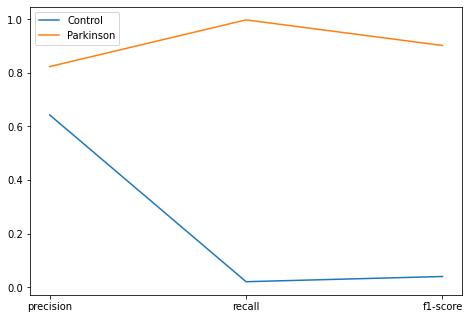

In [222]:

fig = plt.figure()

ax = fig.add_axes([0,0,1,1])

ax.plot(df1['Control'],label = 'Control')
ax.plot(df1['Parkinson'],label='Parkinson')

ax.legend(loc =0)

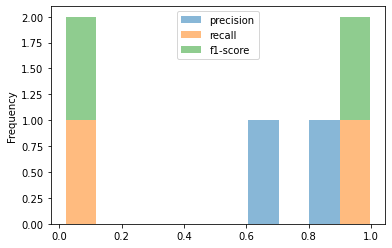

In [218]:
df1.T.plot.hist(bins=10,alpha=0.53,stacked=True)

In [170]:
report_df.accuracy

precision    0.823002
recall       0.823002
f1-score     0.823002
support      0.823002
Name: accuracy, dtype: float64

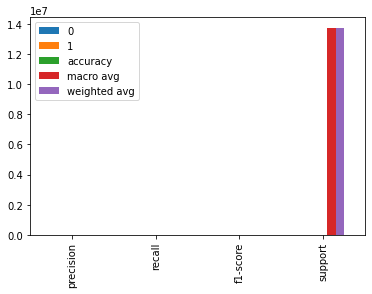

In [173]:
ax = report_df.plot.bar()

In [182]:
report_df.T

,precision,recall,f1-score,support
0,0.642857,0.020690,0.040089,4.350000e+02
1,0.823237,0.997486,0.902023,1.989000e+03
accuracy,0.823002,0.823002,0.823002,8.230018e-01
macro avg,0.790197,0.818568,0.744144,1.377120e+07
weighted avg,0.814804,0.951821,0.861728,1.377120e+07


In [184]:
report_dff =report_df.T 
report_dff

,precision,recall,f1-score,support
0,0.642857,0.020690,0.040089,4.350000e+02
1,0.823237,0.997486,0.902023,1.989000e+03
accuracy,0.823002,0.823002,0.823002,8.230018e-01
macro avg,0.790197,0.818568,0.744144,1.377120e+07
weighted avg,0.814804,0.951821,0.861728,1.377120e+07


IndexError: ignored

In [203]:
report_dff[:2]['f1-score']

0    0.040089
1    0.902023
Name: f1-score, dtype: float64

In [208]:
sns.catplot(x=report_dff.index[:1],y=report_dff.index[:2],kind='bar',hue=report_dff[:2]['precision'],data=report_dff)

ValueError: ignored

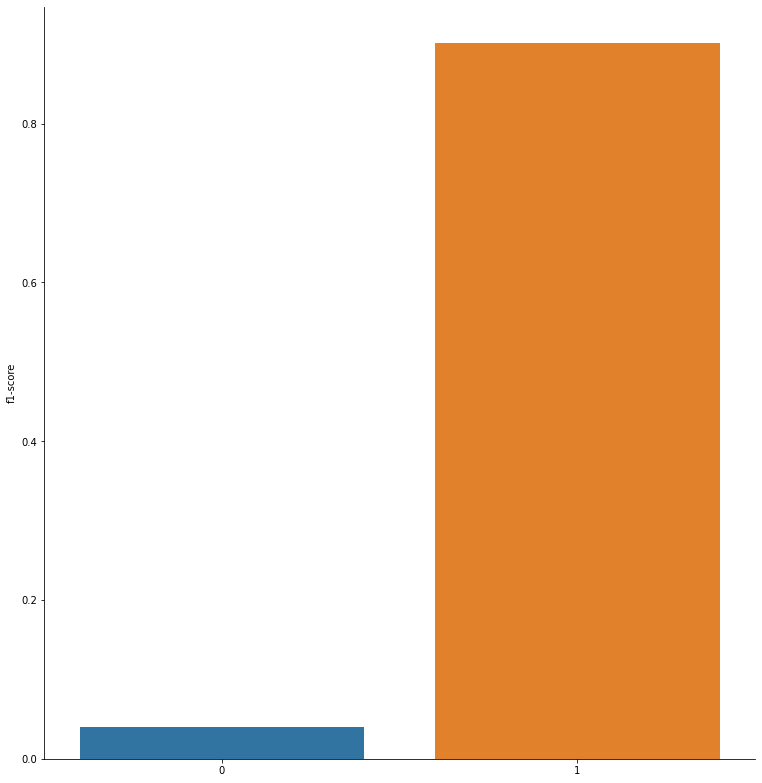

In [204]:
g = sns.catplot(x=report_dff.index[:2],y=report_dff[:2]['f1-score'],kind='bar',data=report_dff)
g.fig.set_figwidth(11.27)
g.fig.set_figheight(11.7)

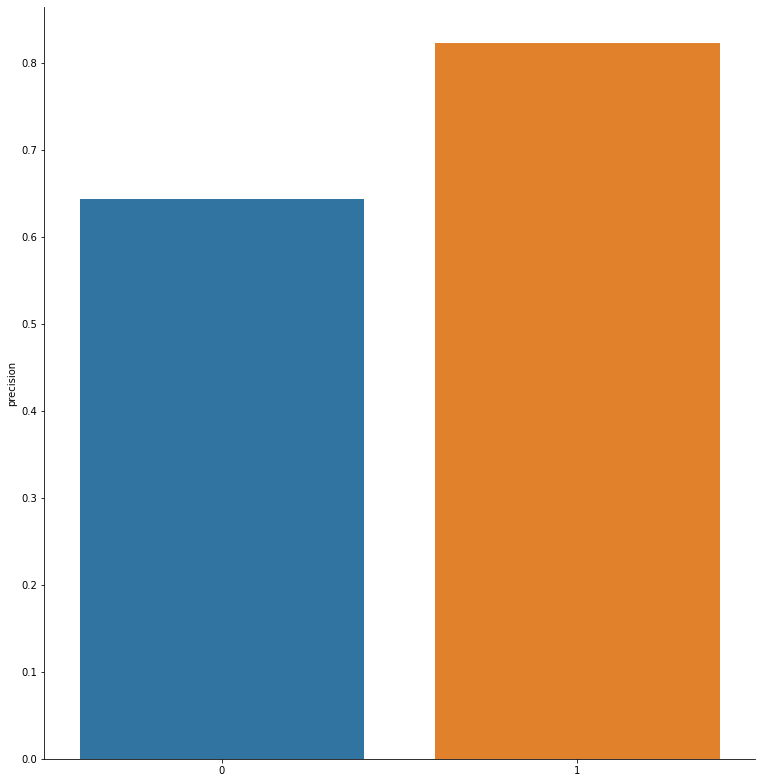

In [205]:
g = sns.catplot(x=report_dff.index[:2],y=report_dff[:2]['precision'],kind='bar',data=report_dff)
g.fig.set_figwidth(11.27)
g.fig.set_figheight(11.7)

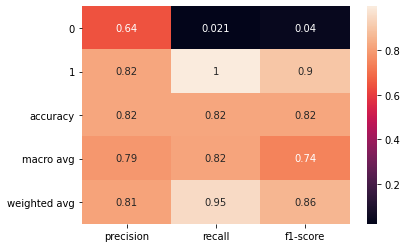

In [85]:
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

In [96]:
# PLOTTING
import matplotlib.pyplot as plt
import scikitplot as skplt

In [131]:
accuracy_score(Y_pred, test_target)

0.8221947194719472

In [109]:
df.index[:2499]

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498],
           dtype='int64', length=2499)

In [120]:
final

,no_strokes_st,no_strokes_dy,speed_st,speed_dy,magnitude_vel_st,magnitude_horz_vel_st,magnitude_vert_vel_st,magnitude_vel_dy,magnitude_horz_vel_dy,magnitude_vert_vel_dy,magnitude_acc_st,magnitude_horz_acc_st,magnitude_vert_acc_st,magnitude_acc_dy,magnitude_horz_acc_dy,magnitude_vert_acc_dy,magnitude_jerk_st,magnitude_horz_jerk_st,magnitude_vert_jerk_st,magnitude_jerk_dy,magnitude_horz_jerk_dy,magnitude_vert_jerk_dy,ncv_st,ncv_dy,nca_st,nca_dy,in_air_stcp,on_surface_st,on_surface_dy,target,Y_pred
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,NaN
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,NaN
2,2.0,6.0,0.001793,0.001434,0.041127,0.026362,0.025751,0.059535,0.037716,0.038586,0.000159,0.000095,0.000098,0.000194,0.000118,0.000118,0.000003,0.000002,0.000002,0.000004,0.000002,0.000002,315.714286,299.666667,212.000000,285.0,705.0,4025.0,2487.0,1.0,NaN
3,22.0,12.0,0.001636,0.001620,0.128316,0.083959,0.079109,0.068212,0.042802,0.043473,0.000409,0.000266,0.000253,0.000270,0.000175,0.000163,0.000005,0.000003,0.000003,0.000004,0.000003,0.000003,205.714286,262.285714,53.666667,83.0,206.0,1369.0,2807.0,1.0,NaN
4,54.0,34.0,0.003032,0.002656,0.092602,0.060102,0.057756,0.104627,0.067375,0.066732,0.000406,0.000235,0.000277,0.000422,0.000244,0.000289,0.000008,0.000004,0.000005,0.000007,0.000004,0.000005,310.000000,334.750000,225.000000,75.5,1497.0,1881.0,1592.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


Text(0, 0.5, 'y')

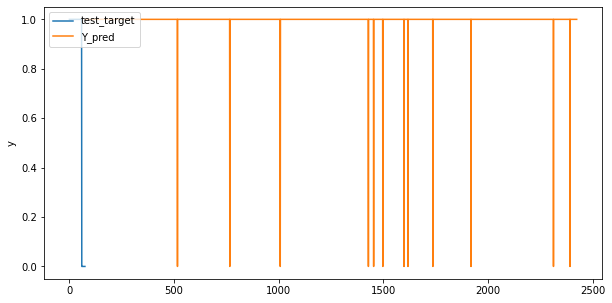

In [128]:

pred = pd.DataFrame(Y_pred, columns = ['Y_pred'])
target = pd.DataFrame(test_target,columns = ['test_target'])
final = pd.concat([train,pred],ignore_index=True,sort=False)
final = final.set_index(df.index[:2499])
plt.figure(figsize=(10,5))
sns.lineplot(x=final.index[:2424], y=final[:2424]['target'])
sns.lineplot(x=final.index[:2424], y=final[:2424]['Y_pred'])
plt.legend(['test_target','Y_pred'],
            loc='upper left')
plt.ylabel('y')

In [86]:
target

array([0, 0, 0, ..., 1, 1, 1])

In [95]:
pip install scikit-plot

In [87]:
control = getControlFeatures()
park = getParkinsonFeatures()
target = getClasses(control,park)
all_data = np.concatenate((control,park),axis= 0)

/usr/local/lib/python3.7/dist-packages/pandas/core/internals/construction.py:305: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  values = np.array([convert(v) for v in values])


In [88]:
all_data

array([[ 233, -308,    0,  311, -152],
       [-211,  220,  205,  161,  -84],
       [ 288, -258,  194, -166,  207],
       ...,
       [ 115,  106,    0,  -53, -105],
       [-102,  104,    0,   41,   48],
       [ -74,  -59,  155,  -38,  139]])

In [89]:
control_path = "/content/drive/MyDrive/Kaggle/datanew/hw_dataset/hw_dataset/control"
parkinson_path = "/content/drive/MyDrive/Kaggle/datanew/hw_dataset/hw_dataset/parkinson"

In [90]:
df_control = pd.read_csv(control_path + '/control_all_with_header.csv')
df_park = pd.read_csv(parkinson_path + '/park_all_with_header.csv')
df = pd.concat([df_control, df_park])

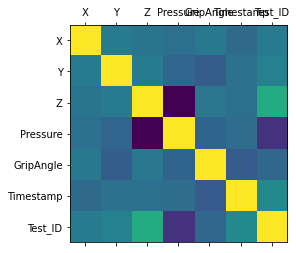

In [91]:
df_corr = df.drop(['Subject', 'PWP'], axis=1)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(df_corr.corr())
plt.xticks(range(len(df_corr.columns)), df_corr.columns)
plt.yticks(range(len(df_corr.columns)), df_corr.columns)
plt.show()

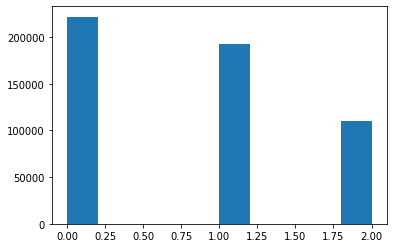

In [92]:
plt.hist(df['Test_ID'])
plt.show()
df_0 = df[df['Test_ID'] == 0]
df_1 = df[df['Test_ID'] == 1]
df_2 = df[df['Test_ID'] == 2]

In [93]:
print(df_0.head())
print(df_1.head())
print(df_2.head())

   Subject    X    Y  Z  Pressure  GripAngle  Timestamp  Test_ID  PWP
0        1  226  234  0        80        960    1283186        0    0
1        1  226  234  0       119        960    1283195        0    0
2        1  226  234  0       161        960    1283204        0    0
3        1  226  234  0       194        980    1283213        0    0
4        1  226  234  0       241        980    1283222        0    0
      Subject    X    Y  Z  Pressure  GripAngle  Timestamp  Test_ID  PWP
3948        1  225  235  0       142       1060    1320323        1    0
3949        1  226  235  0       191       1070    1320332        1    0
3950        1  226  235  0       276       1070    1320341        1    0
3951        1  226  235  0       327       1060    1320350        1    0
3952        1  226  235  0       366       1050    1320359        1    0
       Subject    X    Y    Z  Pressure  GripAngle  Timestamp  Test_ID  PWP
39654        5  242  247  682         0       2330    6551462     